### Setup

Change the HF_HOME directory if needed. What is below is obviously hard-coded for Arjun's account.

In [1]:
import os
os.environ["HF_HOME"] = "/work/arjunguha-research-group/arjun/cache/hf_home"

In [2]:
# Enable retina mode for high-resolution plots
%config InlineBackend.figure_format = 'retina'

import numpy as np
from pathlib import Path
import pandas as pd
import json
import gzip
from typing import Optional, Union
from matplotlib import pyplot as plt
import seaborn as sns


In [3]:
ARCHIVE_PATH = "/work/arjunguha-research-group/projects/prompt_trajectories/causal_intervention"

### Load Results after Interventions

In [4]:
def gunzip_json(path: Union[Path, str]) -> Optional[dict]:
    """
    Reads a .json.gz file, but produces None if any error occurs.
    """
    try:
        with gzip.open(path, "rt") as f:
            data = json.load(f)
            return data
    except Exception as e:
        return None

def process_multiple_result_file(p: Union[Path, str], extras: dict): 
    data = gunzip_json(p)
    n_completions = len(data["results"])
    n_successes = sum(1 for item in data["results"] if item["status"] == "OK")
    assert "prompt" not in extras
    assert "problem" not in extras
    assert "studenteval_id" not in extras
    assert "pass1" not in extras
    return {
        "prompt": data["prompt"],
        "problem": data["problem"],
        "studenteval_id": data["__index_level_0__"],
        "pass1": n_successes / n_completions,
        "n_successes": n_successes,
        "n_completions": n_completions,
        "path": str(p),
        **extras
    }

def process_multiple_dir(p: Union[Path, str], extras: dict):
    if type(p) == str:
        p = Path(p)
    
    items = [ ]
    for results_json in p.glob("*"):
        if not results_json.name.endswith(".results.json.gz"):
            continue
        items.append(process_multiple_result_file(results_json, extras))
    return items
    
def process_single_intervention_dir(p: Union[Path, str], extras: dict):
    assert "intervention_category" not in extras
    assert "intervention" not in extras

    if type(p) == str:
        p = Path(p)

    # Example of dir_name: generations_all.prompts.full.label.d2c1570_return_return
    dir_name = p.name
    git_hash_and_intervention_category = dir_name.split(".")[-2]
    intervention_category = git_hash_and_intervention_category.split("_", maxsplit=1)[1]
    intervention = dir_name.split(".")[-1]
    # The code below was needed for the old name structure
    # git_hash_and_rest = dir_name.split(".")[-1]
    #[git_hash, intervention_category, intervention] = git_hash_and_rest.split("_", maxsplit=2)
    if intervention_category == "loop":
        intervention_category = "loop_through"
        through, intervention = intervention.split("_", maxsplit=1)
        assert through == "through"
    more_extras = {
        "intervention_category": intervention_category,
        "intervention": intervention,
        **extras
    }

    return process_multiple_dir(p / "multiple", more_extras)

def process_all_interventions_dir(p: Union[Path, str], extras: dict):
    if type(p) == str:
        p = Path(p)

    items = [ ]
    for d in p.glob("*"):
        if "studenteval" in d.name:
            # Not the best directory organization. This is shade at Arya.
            continue
        if not d.is_dir():
            # Won't happen, right?
            continue
        items.extend(process_single_intervention_dir(d, extras))
    return items

The cell below takes up to 5 minutes to run on Discovery.

In [5]:
def load_all_interventions(model_name: str):
    base_df = pd.DataFrame(
        process_multiple_dir(
            f"{ARCHIVE_PATH}/{model_name}/studenteval/multiple", 
            { "model": model_name } 
        )
    )

    df = pd.DataFrame(process_all_interventions_dir(
        f"{ARCHIVE_PATH}/{model_name}/interventions",
        { "model": model_name }
    ))

    base_merged_df = pd.merge(df, base_df, on="studenteval_id")
    assert len(df) == len(base_merged_df)
    return base_merged_df

llama3p1_8b_base_df = load_all_interventions("llama3p1_8b_base")
llama3p1_70b_base_df = load_all_interventions("llama3p1_70b_base")

assert len(llama3p1_8b_base_df) == len(llama3p1_70b_base_df)
assert len(llama3p1_8b_base_df) == 13456

### Post-hoc Determine Original Words

`WORDS_V` below is copied from another file. Loading it loads Spacey, which is
very annoying. We should actually move WORDS_V to a separate file.

In [6]:
WORDS_V = {
    "word":["word","words"],
    "phrase":["phrase","phrases"],
    "string":["string","strings"],
    "character":["character","characters"],
    "set of characters":["set of characters","sets of characters"],
    "brackets":["brackets"],
    "set of brackets":["set of brackets","sets of brackets"],
    "set":["set","sets"],
    "list":["list","lists"],
    "array":["array","arrays"],
    "array list":["array list","array lists"],
    "map":["map","maps"],
    "dictionary":["dictionary","dictionaries"],
    "integer":["integer","integers"],
    "whole number":["whole number","whole numbers"],
    "int":["int","ints"],
    "output":["output","outputs","outputted","outputting"],
    "return":["return","returns","returned","returning"],
    "print":["print","prints","printed","printing"],
    "produce":["produce","produces","produced","producing"],
    "display":["display","displays","displayed","displaying"],
    "parameter":["parameter","parameters"],
    "argument":["argument","arguments"],
    "value provided":["value provided","values provided"],
    "input":["input","inputs","inputted"],
    "take":["take","takes"],
    "bring in":["bring in","brings in"],
    "accept":["accept","accepts"],
    "get":["get","gets"],
    "provide":["provide","provides","provided"],
    "enter":["enter","enters","entered"],
    "combine":["combine","combines","combined","combining"],
    "splice":["splice","splices","spliced","splicing"],
    "concatenate":["concatenate","concatenates","concatenated","concatenating"],
    "add":["add","adds","added","adding"],
    "insert":["insert","inserts","inserted","inserting"],
    "attach":["attach","attaches","attached","attaching"],
    "append":["append","appends","appended","appending"],
    "go through":["go through","goes through"],
    "run through":["run through","runs through"],
    "iterate through":["iterate through","iterates through"],
    "loop through":["loop through","loops through"],
    "run a for loop through":["run a for loop through","runs a for loop through"],
    "look through":["look through","looks through"],
    "execute a for loop with":["execute a for loop with","executes a for loop with"],
    "skip":["skip","skips","skipped","skipping"],
    "avoid":["avoid","avoids","avoided","avoiding"],
    "neglect":["neglect","neglects","neglected","neglecting"],
    "ignore":["ignore","ignores","ignored","ignoring"],
    "remove":["remove","removes","removed","removing"],
    "convert":["convert","converts","converted","converting"],
    "change":["change","changes","changed","changing"],
    "typecast":["typecast","typecasts","typecasted","typecasting"],
    "type cast":["type cast","type casts","type casted","type casting"],
    "cast":["cast","casts","casted","casting"],
    "key":["key","keys"],
    "item":["item","items"],
    "entry":["entry","entries"],
    "attribute":["attribute","attributes"],
    "part":["part","parts"],
    "element":["element","elements"],
    "variable":["variable","variables"],
}

def process_jsonl_with_original(p: Union[Path, str]):
    if type(p) == str:
        p = Path(p)

    # Example of dir_name: generations_all.prompts.full.label.d2c1570_return_return
    dir_name = p.name
    git_hash_and_rest = dir_name.split(".")[-2]
    [git_hash, intervention_category, intervention] = git_hash_and_rest.split("_", maxsplit=2)
    if intervention_category == "loop":
        intervention_category = "loop_through"
        through, intervention = intervention.split("_", maxsplit=1)
        assert through == "through"
    jsonl = pd.read_json(p, lines=True)
    jsonl["intervention_category"] = intervention_category
    jsonl["intervention"] = intervention
    jsonl["studenteval_id"] = jsonl["__index_level_0__"]
    return jsonl[["original", "intervention_category", "intervention", "studenteval_id"]]

MISSING_TERMS = set()
def get_original(item):
    # Find original_tags_df.original in values (a list) of CATEGORIES_V. Use the key for that category as the new value.
    item = str(item["original"].lower())
    for k, v in WORDS_V.items():
        if item in v:
            return k.replace(" ", "_")
    return item
    
original_word_dfs = [ ]
for p in (Path(ARCHIVE_PATH) / "intervention_prompts").glob("*.jsonl"):
    original_word_dfs.append(process_jsonl_with_original(p))
original_words_df = pd.concat(original_word_dfs)
original_words_df["original_word"] = original_words_df.apply(get_original, axis=1)
assert len(original_words_df) == len(llama3p1_8b_base_df)
original_words_df.head()

,original,intervention_category,intervention,studenteval_id,original_word
0,append,concatenate,add,235,append
1,combined,concatenate,add,1461,combine
2,concatenate,concatenate,add,1583,concatenate
3,added,concatenate,add,1747,add
4,append,concatenate,add,255,append


In [7]:
original_words_df.intervention_category.unique()

array(['concatenate', 'dictionary', 'insert', 'integer', 'key', 'list',
       'loop_through', 'parameter', 'provide', 'return', 'skip', 'string',
       'take', 'typecast'], dtype=object)

### Merging Intervened Prompt with Original Tags

In [8]:
def add_original_words(df):
    merged_df = pd.merge(df, original_words_df, on=["studenteval_id", "intervention_category", "intervention"])
    merged_df["pass1_diff"] = merged_df.pass1_x - merged_df.pass1_y
    assert len(merged_df) == len(df)
    return merged_df

llama3p1_8b_with_originals_df = add_original_words(llama3p1_8b_base_df)
llama3p1_70_with_originals_df = add_original_words(llama3p1_70b_base_df)

### Combining Rare Expressions into an Other

In [9]:
def combine_rare_expressions(df):
    # Group by original_word and intervention_category
    def grouper(x):
        return len(x) < 3
    grouped_df = df.groupby(['original_word', 'intervention']).filter(grouper)

    # Create an updated version of merged_df where the original_word for all of
    # the rows selected above is set to "other"
    simplified_df = df.copy()
    simplified_df.loc[grouped_df.index, 'original_word'] = 'other'
    return simplified_df

llama3p1_8b_with_others_df = combine_rare_expressions(llama3p1_8b_with_originals_df)
llama3p1_70b_with_others_df = combine_rare_expressions(llama3p1_70_with_originals_df)


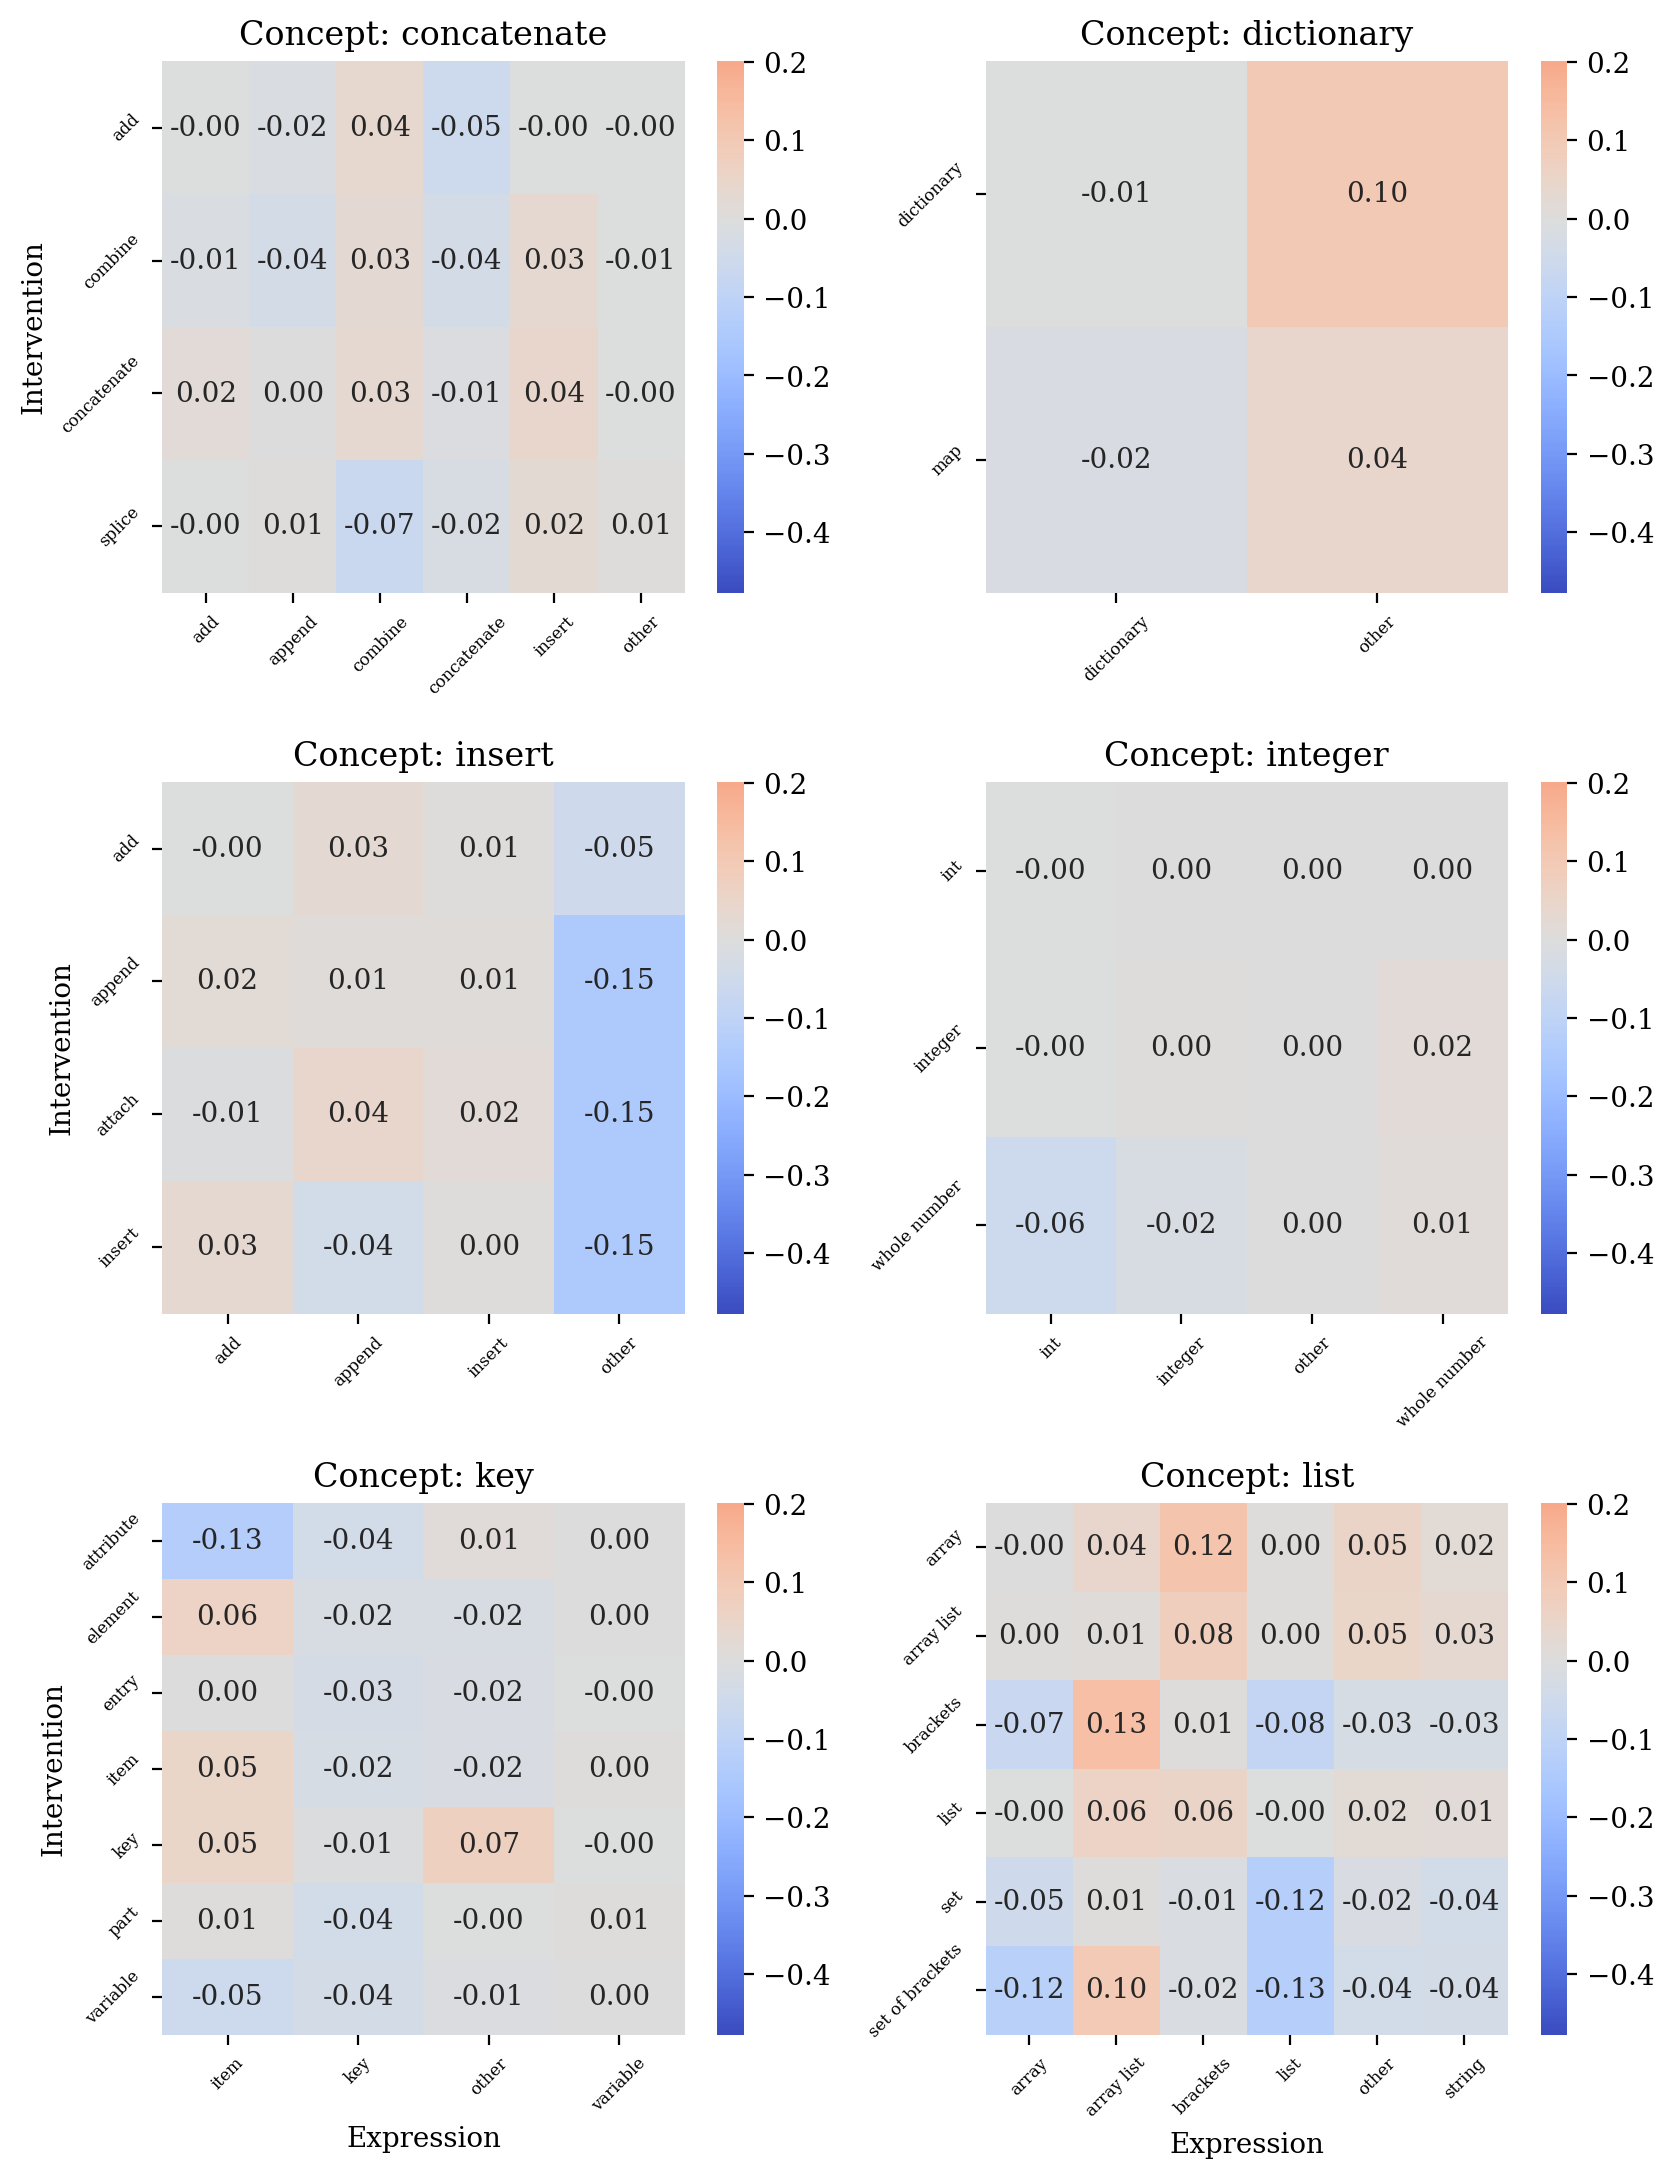

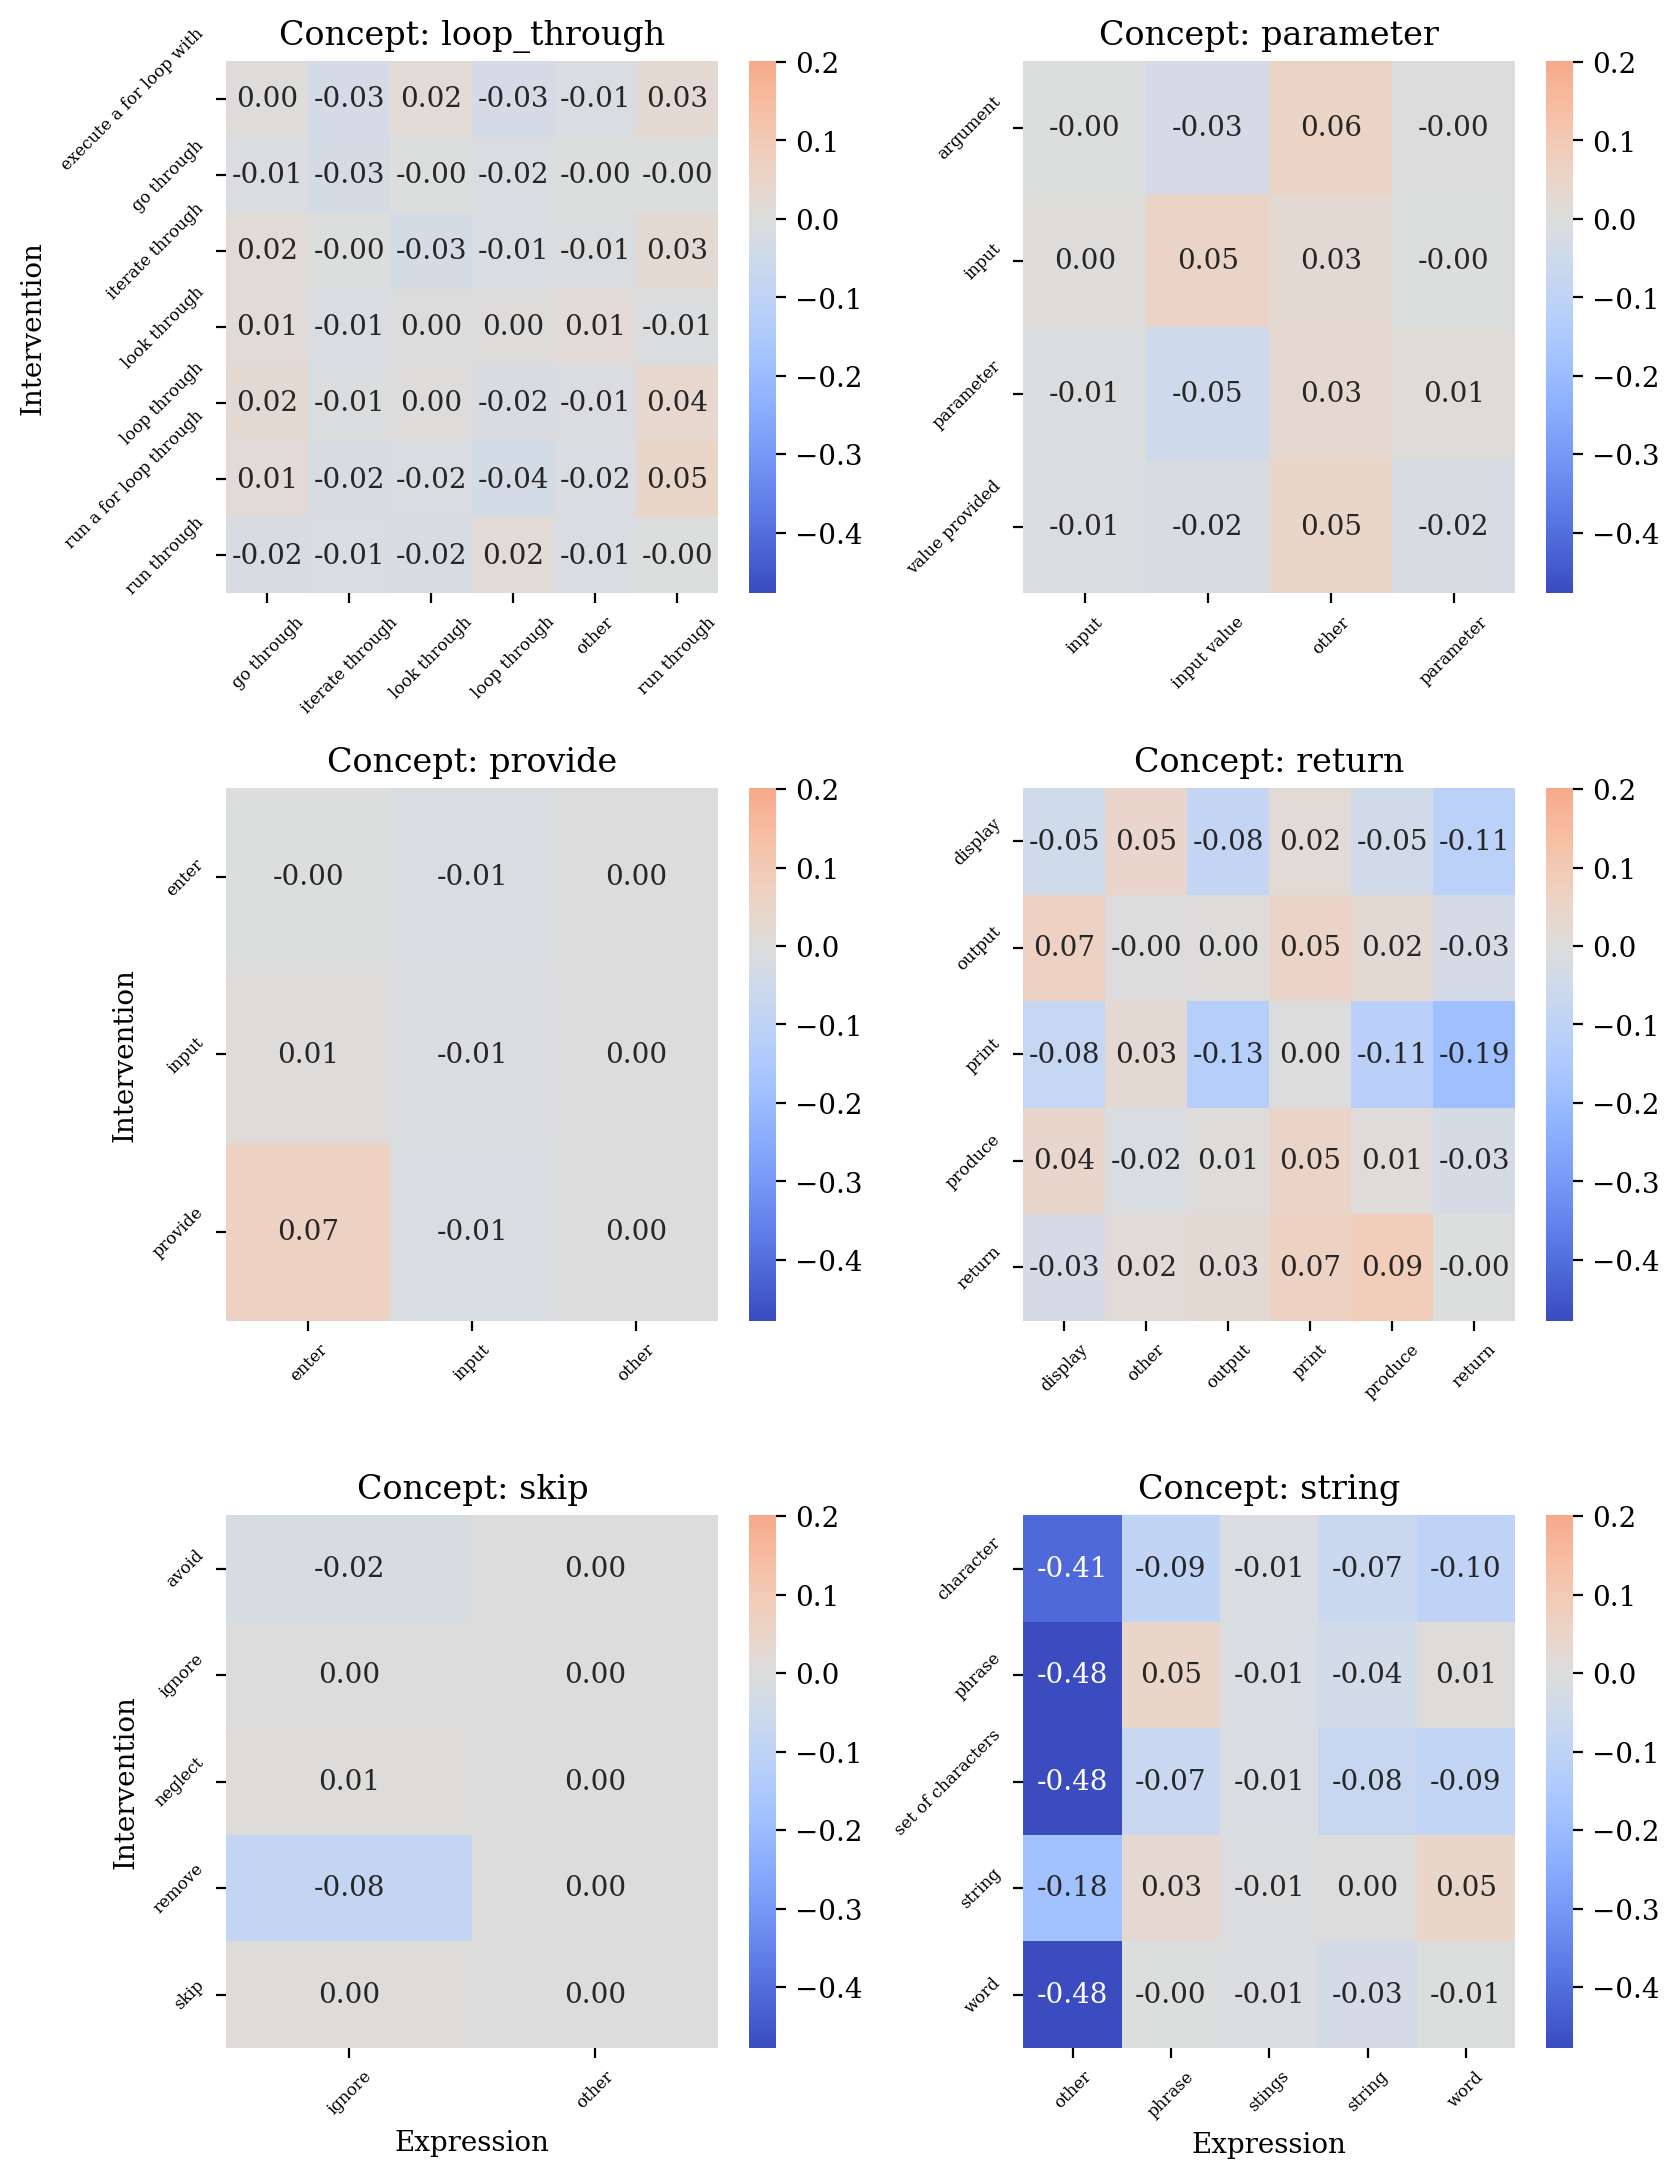

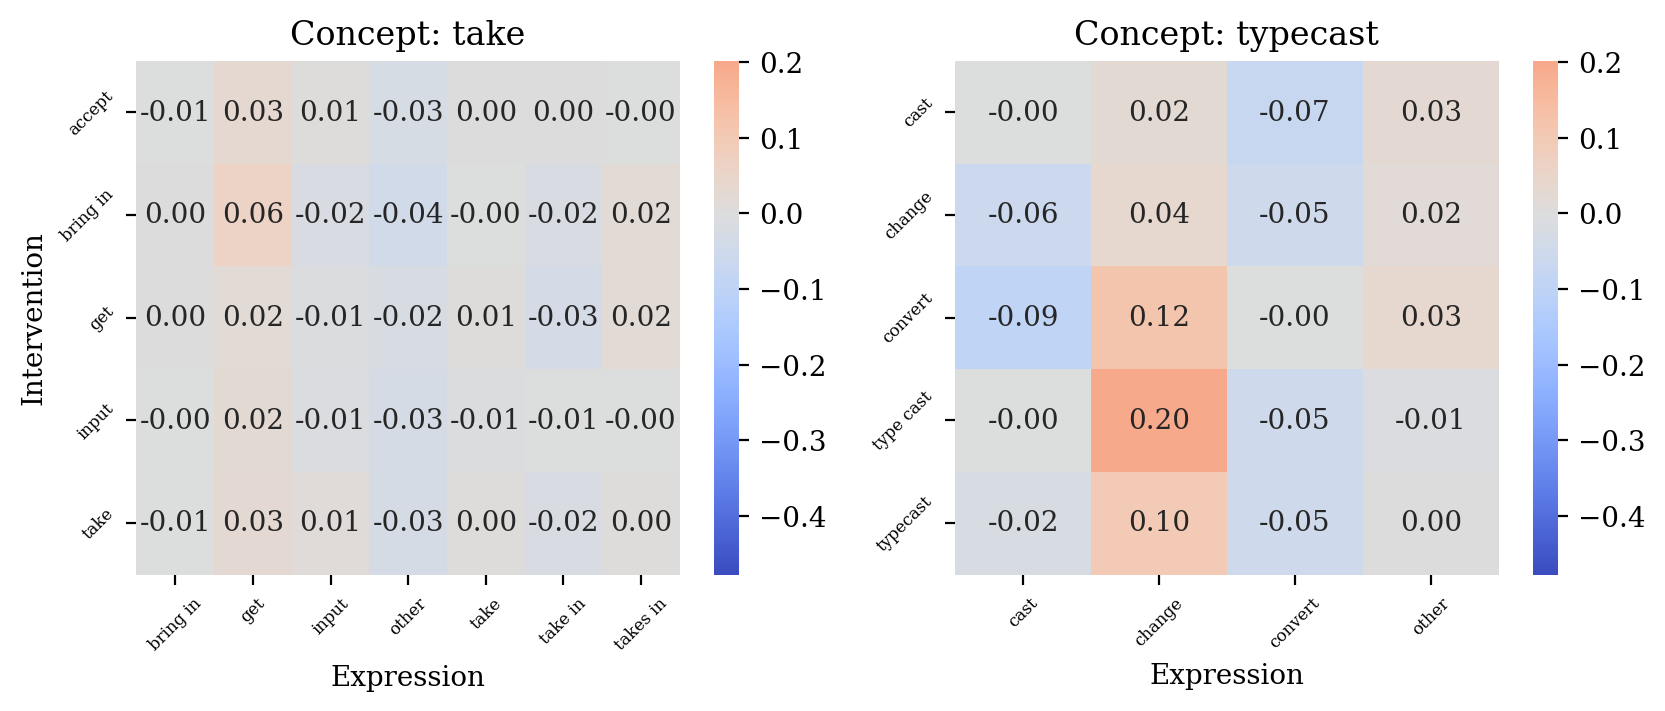

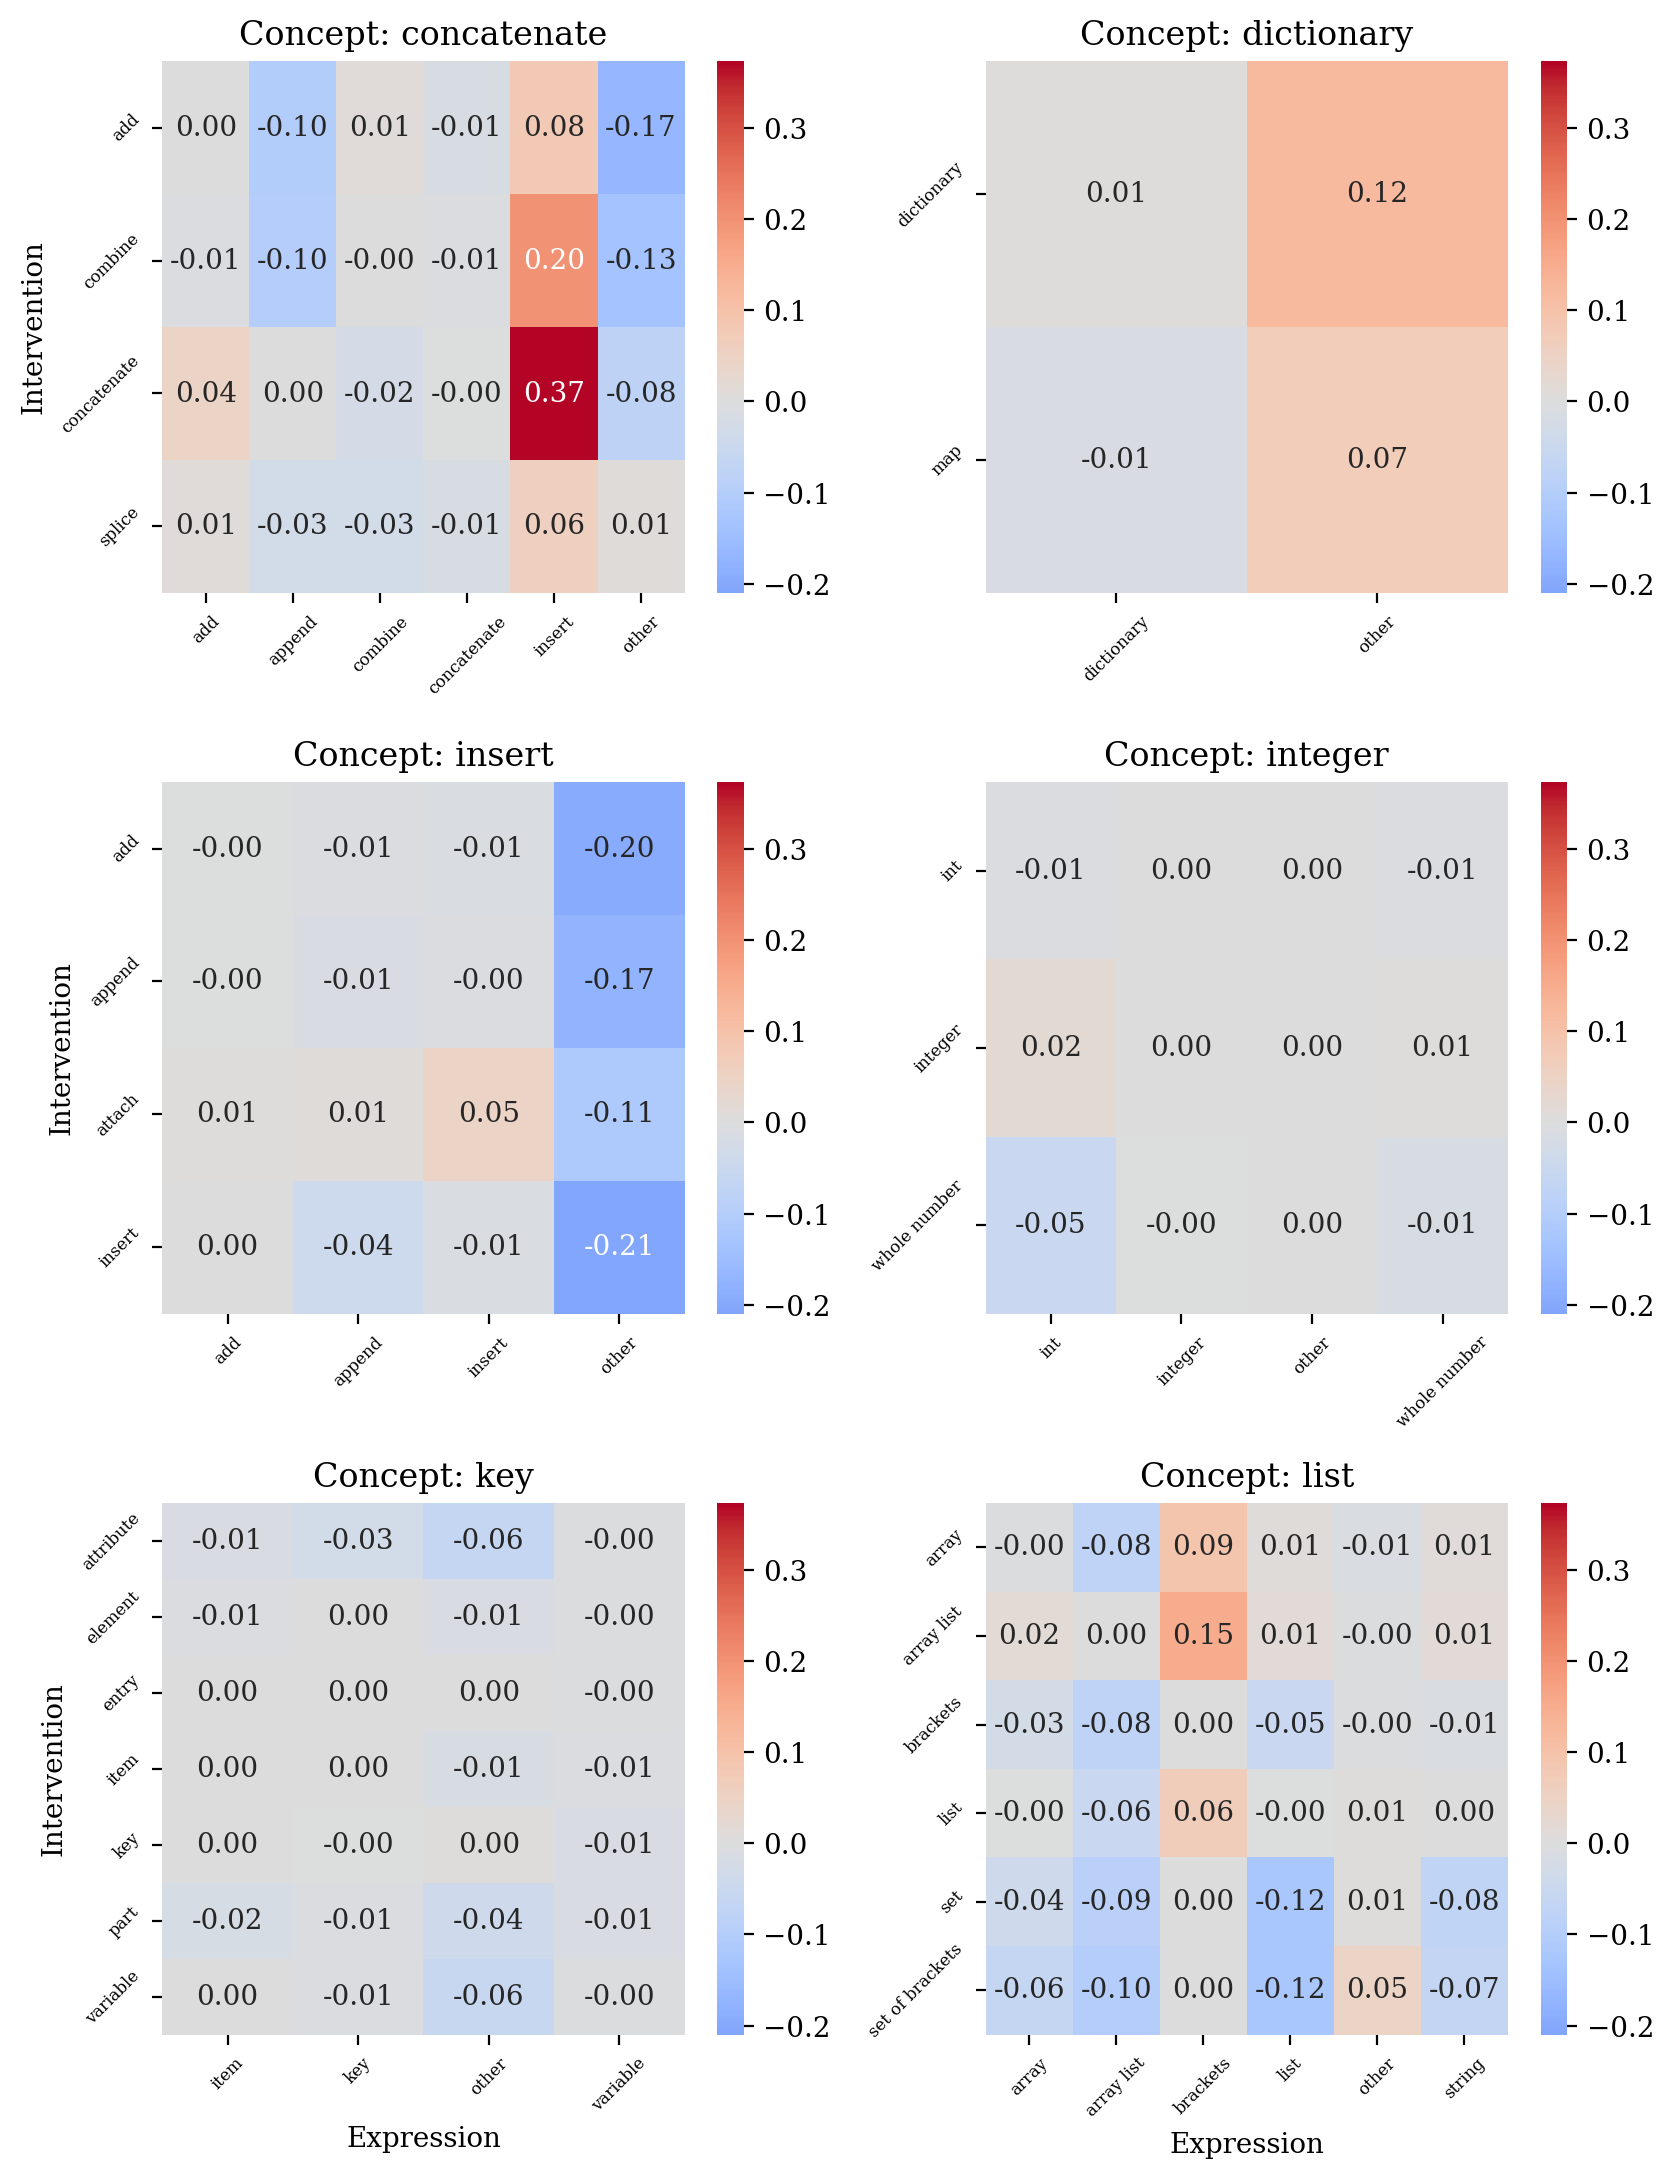

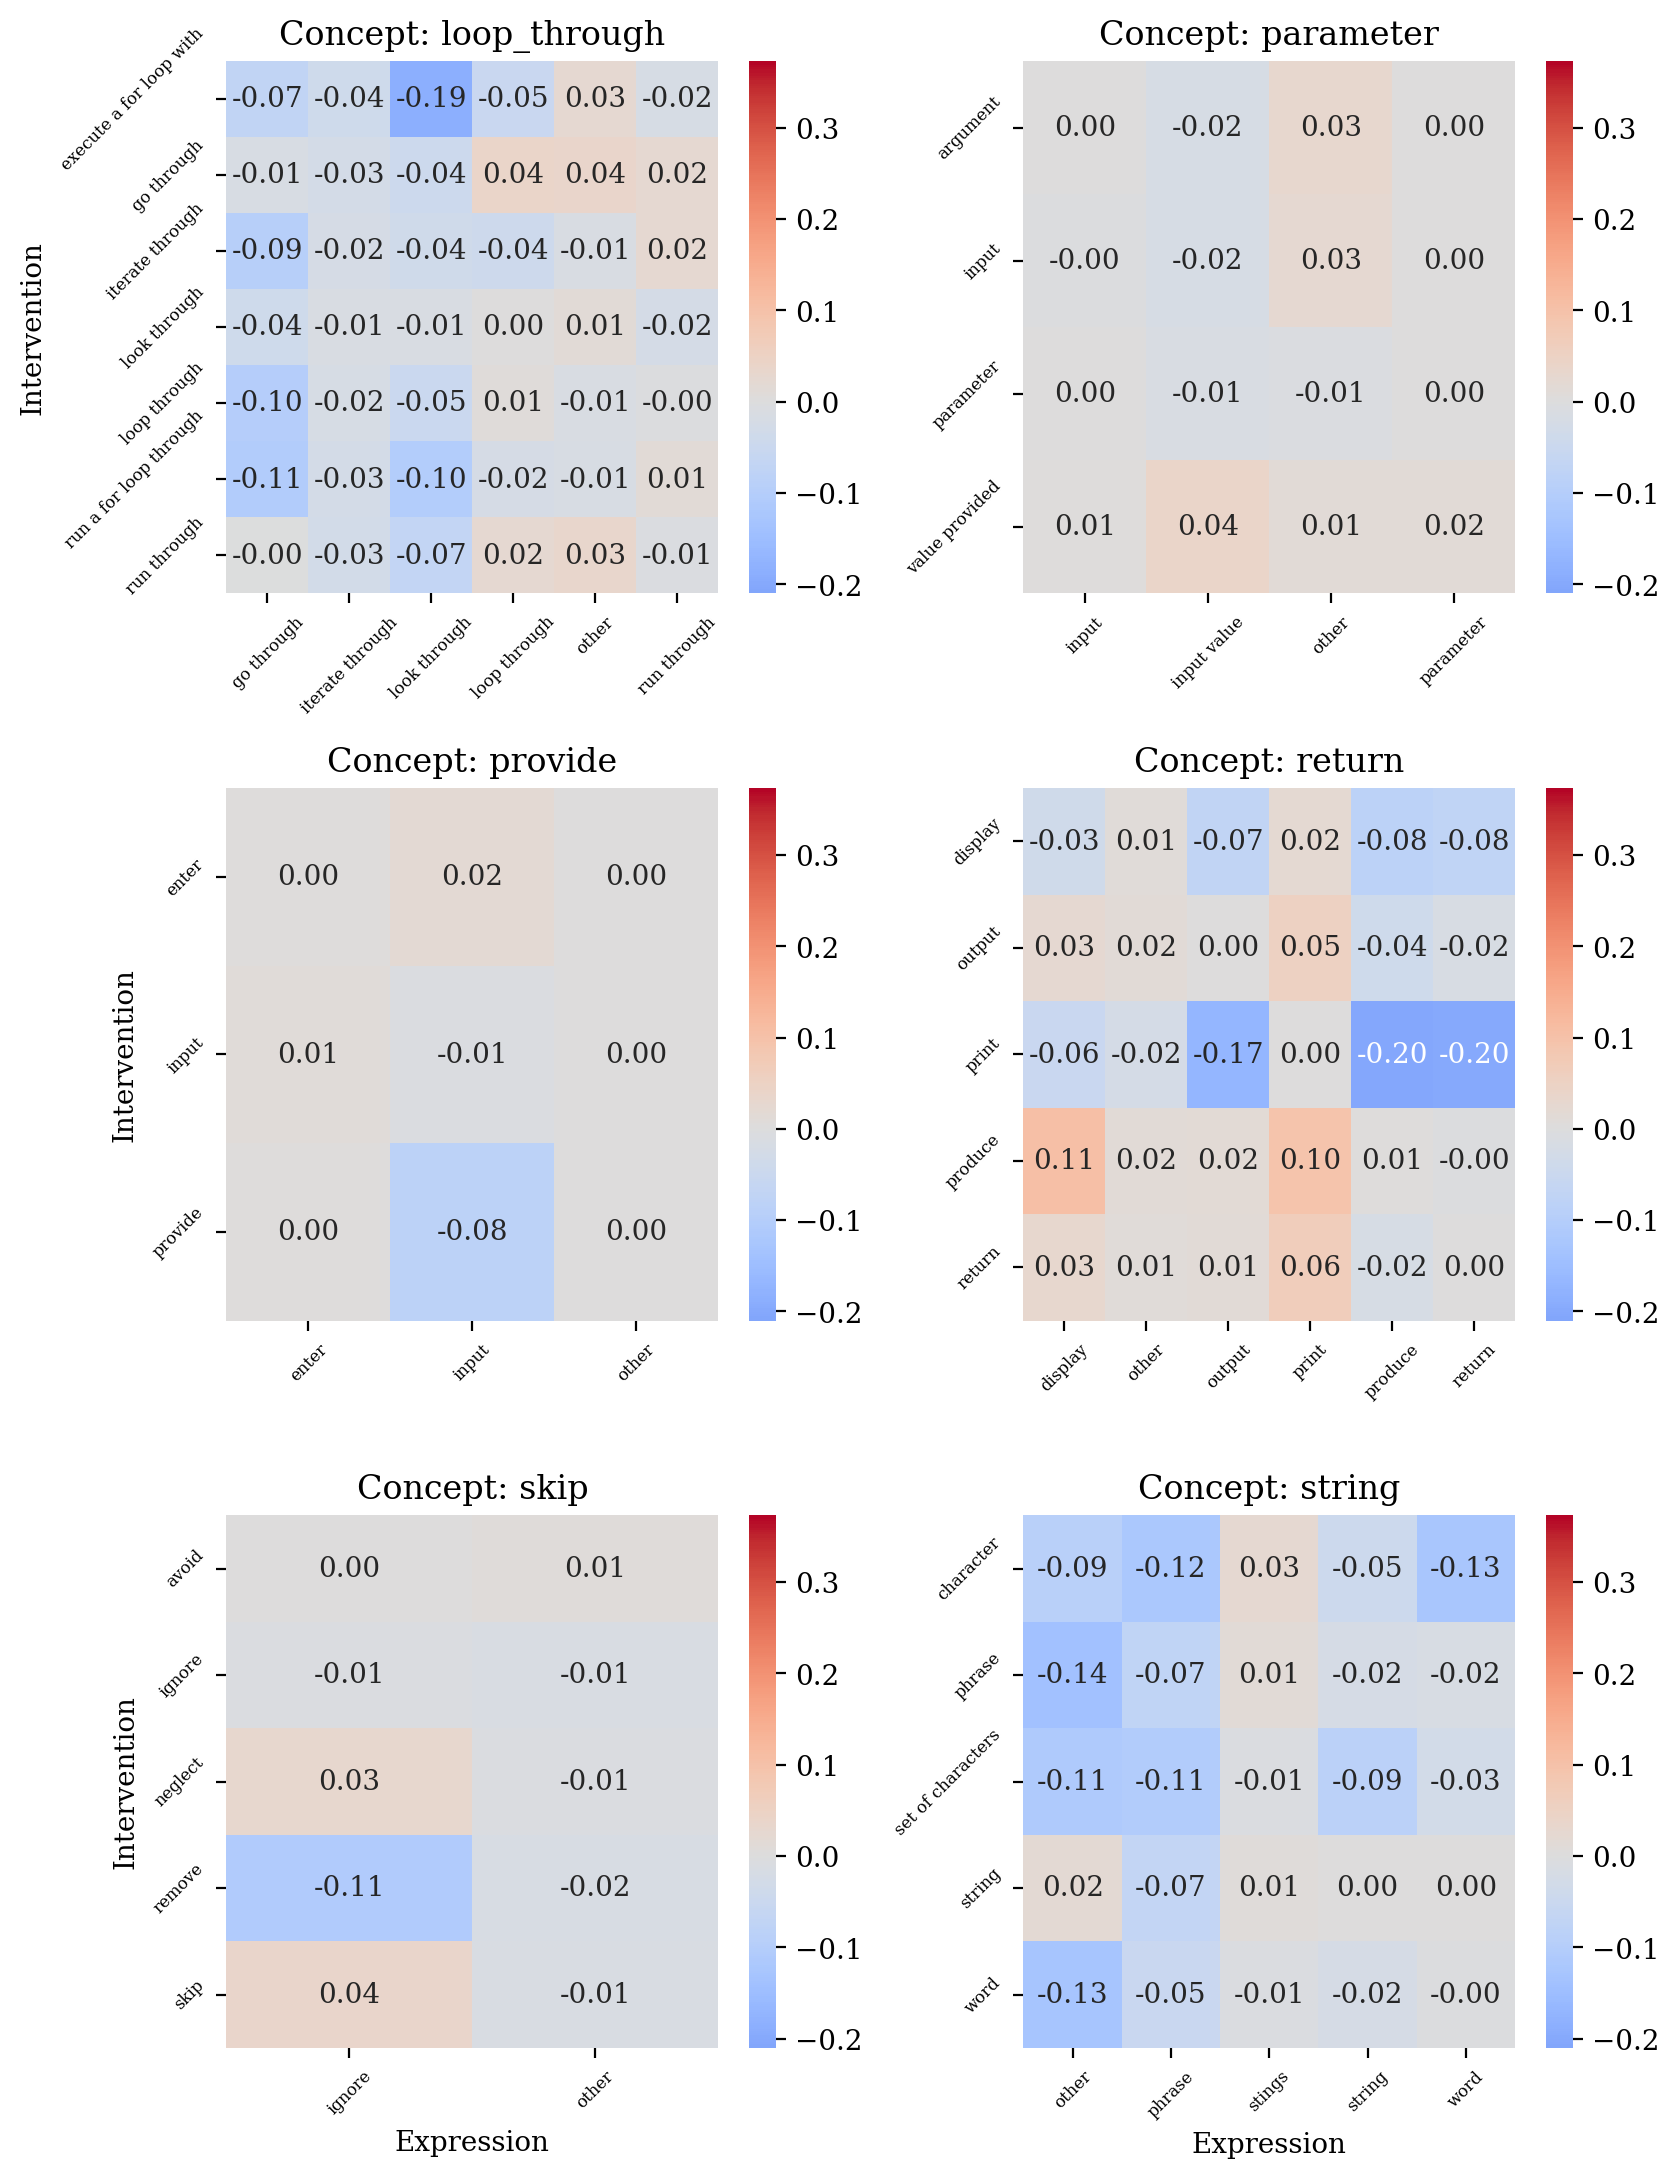

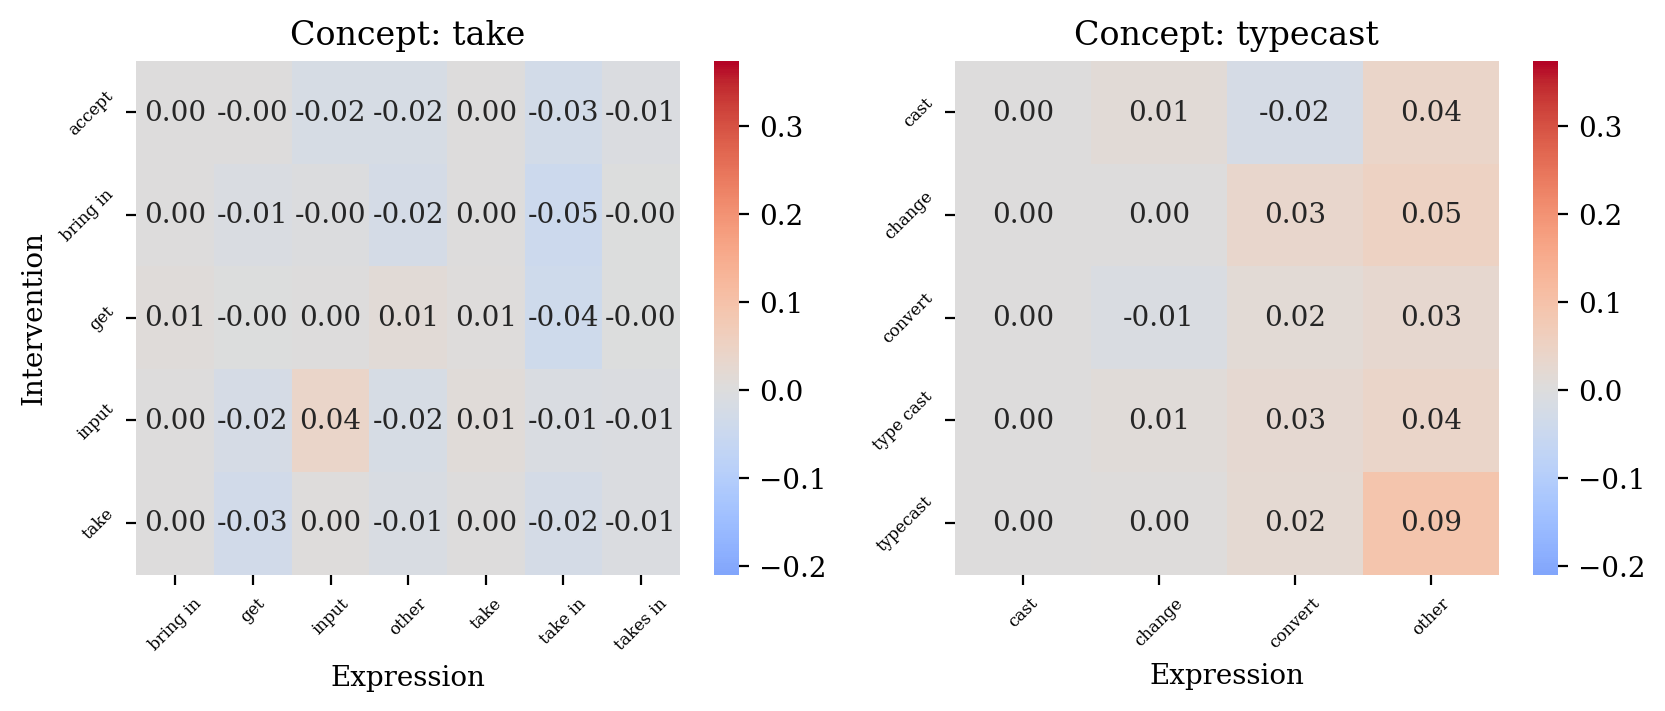

In [10]:
plt.rc('font', family='serif')


def plot_heatmap(df, intervention_categories, output_path, nrows=3, ncols=2, figsize=(8.5, 11)):
    global axes
    assert len(intervention_categories) <= 6
    # Create a figure with subplots for each intervention category
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    
    axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing

    # Determine the range of values for the heatmaps
    category_means = df.groupby(['original_word', 'intervention'])["pass1_diff"].mean()
    vmin = category_means.min()
    vmax = category_means.max()

    for idx, category in enumerate(intervention_categories):
        category_df = df[df.intervention_category == category].copy()
        category_df['intervention'] = category_df['intervention'].str.replace('_', ' ')
        category_df['original_word'] = category_df['original_word'].str.replace('_', ' ')

        # Pivot the dataframe to create matrices for mean and count
        heatmap_data_mean = category_df.pivot_table(values='pass1_diff', 
                                                    index='intervention', 
                                                    columns='original_word', 
                                                    aggfunc='mean')
        heatmap_data_count = category_df.pivot_table(values='pass1_diff', 
                                                    index='intervention', 
                                                    columns='original_word', 
                                                    aggfunc='count')

        # Combine mean and count into a single string for each cell
        heatmap_data_combined = heatmap_data_mean.map(lambda x: f'{x:.2f}')

        # Create the heatmap on the corresponding subplot
        sns.heatmap(heatmap_data_mean, annot=heatmap_data_combined, fmt='', 
                    cmap='coolwarm', center=0, ax=axes[idx], 
                    vmin=vmin, vmax=vmax)
        axes[idx].tick_params(axis='x', rotation=45, labelsize=6)
        axes[idx].tick_params(axis='y', rotation=45, labelsize=6)
        if idx >= len(intervention_categories) - 2:
            axes[idx].set_xlabel("Expression")
        else:
            axes[idx].set_xlabel("")
        if idx % 2 == 0:
            axes[idx].set_ylabel("Intervention")
        else:
            axes[idx].set_ylabel("")

        # Set the title for each subplot
        axes[idx].set_title(f'Concept: {category}')

    # Adjust layout and display the plot
    plt.tight_layout()
    # Save to PDF
    plt.savefig(output_path, format="pdf")
    plt.show()

# Get unique intervention categories
intervention_categories = list(llama3p1_8b_with_others_df.intervention_category.unique())

plot_heatmap(llama3p1_8b_with_others_df, intervention_categories[:6], "pass1_diff_llama3p1_8b_heatmap_1.pdf")
plot_heatmap(llama3p1_8b_with_others_df, intervention_categories[6:12], "pass1_diff_llama3p1_8b_heatmap_2.pdf")
plot_heatmap(llama3p1_8b_with_others_df, intervention_categories[12:], "pass1_diff_llama3p1_8b_heatmap_3.pdf", nrows=1, ncols=2, figsize=(8.5, 11 / 3))

plot_heatmap(llama3p1_70b_with_others_df, intervention_categories[:6], "pass1_diff_llama3p1_70b_heatmap_1.pdf")
plot_heatmap(llama3p1_70b_with_others_df, intervention_categories[6:12], "pass1_diff_llama3p1_70b_heatmap_2.pdf")
plot_heatmap(llama3p1_70b_with_others_df, intervention_categories[12:], "pass1_diff_llama3p1_70b_heatmap_3.pdf", nrows=1, ncols=2, figsize=(8.5, 11 / 3))



### For Mixed-Effect Models

In [11]:

def dump_csv_for_mixed_effects(df, filename):
    output_df = df[["studenteval_id", "problem_x", "n_successes_x", "pass1_x", "intervention_category", "intervention", "original_word", "n_successes_y", "pass1_y"]].copy()
    output_df.rename(columns = {
        "studenteval_id": "prompt_id",
        "problem_x": "problem",
        "n_successes_y": "n_successes_original",
        "pass1_y": "pass1_original",
        "n_successes_x": "n_successes_intervened",
        "pass1_x": "pass1_intervened",
    }, inplace=True)
    output_df["model"] = "llama3p1_8b_base"
    output_df.head()
    output_df.to_csv(filename, index=False)

dump_csv_for_mixed_effects(llama3p1_8b_with_others_df, "pass1_diff_llama3p1_8b_for_mixed_effects.csv")
dump_csv_for_mixed_effects(llama3p1_70b_with_others_df, "pass1_diff_llama3p1_70b_for_mixed_effects.csv")
